In [1]:

import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
cnx = sqlite3.connect('fishing.db')

data = pd.read_sql_query("SELECT * FROM fishing", cnx)
cnx.close()
df=data.copy()
df

,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp
0,2009-03-08,Changi,0.0,7.0,11.2,E,35.0,E,ESE,15.0,...,60.0,54.0,MED,Med,4.0,5.0,No,No,blue,33.4
1,2014-11-12,Woodlands,0.0,8.4,9.6,WNW,37.0,NNE,NW,13.0,...,60.0,56.0,MeD,LOw,1.0,2.0,None,Yes,blue,35.4
2,2008-08-08,Woodlands,0.0,7.6,11.1,ESE,52.0,SE,E,19.0,...,NaN,13.0,Med,MEd,0.0,0.0,None,No,blue,32.8
3,2015-10-12,Changi,0.0,7.2,11.4,NE,31.0,NNW,NE,9.0,...,51.0,53.0,hIgh,med,1.0,1.0,No,No,red,31.4
4,2013-10-27,Woodlands,5.6,7.0,8.5,NNW,33.0,N,N,13.0,...,68.0,64.0,meD,MeD,6.0,5.0,None,No,grey,35.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12992,2015-06-12,Tuas,0.4,1.6,5.6,SW,28.0,None,SW,0.0,...,92.0,66.0,MEd,mED,4.0,3.0,No,No,red,29.3
12993,2016-09-29,Changi,0.0,7.4,0.6,NNW,35.0,N,NNW,4.0,...,57.0,48.0,LOw,LoW,7.0,8.0,No,Yes,white,31.3
12994,2011-05-14,Sentosa,8.0,0.8,5.4,S,52.0,WSW,S,24.0,...,87.0,64.0,HiGH,HIgH,NaN,NaN,Yes,Yes,grey,26.4
12995,2011-02-14,Sentosa,4.4,4.4,12.0,S,31.0,SSE,SSE,13.0,...,68.0,52.0,hiGH,hIgh,5.0,1.0,Yes,No,blue,30.5


# Cleaning and Filling starts here

### sunshine has negative data doing absolute

In [3]:
df['Sunshine'].value_counts()

 0.0     383
 10.8    271
 11.0    268
 11.1    265
 10.9    252
        ... 
-3.4       1
-0.6       1
-13.5      1
-1.9       1
-1.7       1
Name: Sunshine, Length: 275, dtype: int64

In [4]:
df['Sunshine']= df['Sunshine'].abs()

In [5]:
df.isnull().sum()

Date                0
Location            0
Rainfall            0
Evaporation        80
Sunshine           58
WindGustDir        84
WindGustSpeed      80
WindDir9am        300
WindDir3pm         52
WindSpeed9am        5
WindSpeed3pm        6
Humidity9am        14
Humidity3pm        27
Pressure9am         2
Pressure3pm         8
Cloud9am          304
Cloud3pm          382
RainToday        3198
RainTomorrow        0
ColourOfBoats       0
AverageTemp         9
dtype: int64

### converting date column to day, month, year - 3 different columns and then deleting date column

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year
del df['Date']

### replacing categorical data with numerical which is ordinal

In [7]:
df['Pressure3pm']=df['Pressure3pm'].str.lower()
df['Pressure9am']=df['Pressure9am'].str.lower()
df['Pressure3pm'].replace({'low' : 1,'med' : 2,'high':3},inplace=True)
df['Pressure9am'].replace({'low' : 1,'med' : 2,'high':3},inplace=True)


checking null

In [8]:
df.isnull().sum()

Location            0
Rainfall            0
Evaporation        80
Sunshine           58
WindGustDir        84
WindGustSpeed      80
WindDir9am        300
WindDir3pm         52
WindSpeed9am        5
WindSpeed3pm        6
Humidity9am        14
Humidity3pm        27
Pressure9am         2
Pressure3pm         8
Cloud9am          304
Cloud3pm          382
RainToday        3198
RainTomorrow        0
ColourOfBoats       0
AverageTemp         9
Month               0
Day                 0
Year                0
dtype: int64

checking df's info

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12997 entries, 0 to 12996
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       12997 non-null  object 
 1   Rainfall       12997 non-null  float64
 2   Evaporation    12917 non-null  float64
 3   Sunshine       12939 non-null  float64
 4   WindGustDir    12913 non-null  object 
 5   WindGustSpeed  12917 non-null  float64
 6   WindDir9am     12697 non-null  object 
 7   WindDir3pm     12945 non-null  object 
 8   WindSpeed9am   12992 non-null  float64
 9   WindSpeed3pm   12991 non-null  float64
 10  Humidity9am    12983 non-null  float64
 11  Humidity3pm    12970 non-null  float64
 12  Pressure9am    12995 non-null  float64
 13  Pressure3pm    12989 non-null  float64
 14  Cloud9am       12693 non-null  float64
 15  Cloud3pm       12615 non-null  float64
 16  RainToday      9799 non-null   object 
 17  RainTomorrow   12997 non-null  object 
 18  Colour

looking at df

In [10]:
df

,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp,Month,Day,Year
0,Changi,0.0,7.0,11.2,E,35.0,E,ESE,15.0,19.0,...,2.0,4.0,5.0,No,No,blue,33.4,3,8,2009
1,Woodlands,0.0,8.4,9.6,WNW,37.0,NNE,NW,13.0,28.0,...,1.0,1.0,2.0,None,Yes,blue,35.4,11,12,2014
2,Woodlands,0.0,7.6,11.1,ESE,52.0,SE,E,19.0,19.0,...,2.0,0.0,0.0,None,No,blue,32.8,8,8,2008
3,Changi,0.0,7.2,11.4,NE,31.0,NNW,NE,9.0,13.0,...,2.0,1.0,1.0,No,No,red,31.4,10,12,2015
4,Woodlands,5.6,7.0,8.5,NNW,33.0,N,N,13.0,19.0,...,2.0,6.0,5.0,None,No,grey,35.4,10,27,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12992,Tuas,0.4,1.6,5.6,SW,28.0,None,SW,0.0,13.0,...,2.0,4.0,3.0,No,No,red,29.3,6,12,2015
12993,Changi,0.0,7.4,0.6,NNW,35.0,N,NNW,4.0,9.0,...,1.0,7.0,8.0,No,Yes,white,31.3,9,29,2016
12994,Sentosa,8.0,0.8,5.4,S,52.0,WSW,S,24.0,28.0,...,3.0,NaN,NaN,Yes,Yes,grey,26.4,5,14,2011
12995,Sentosa,4.4,4.4,12.0,S,31.0,SSE,SSE,13.0,9.0,...,3.0,5.0,1.0,Yes,No,blue,30.5,2,14,2011


replacing raintoday and raintomorrow column with binary classification where 0 is no and 1 is yes

In [11]:
df['RainToday'].replace({'No' : 0,'Yes' : 1},inplace=True)
df['RainTomorrow'].replace({'No' : 0,'Yes' : 1},inplace=True)

In [12]:
df

,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp,Month,Day,Year
0,Changi,0.0,7.0,11.2,E,35.0,E,ESE,15.0,19.0,...,2.0,4.0,5.0,0.0,0,blue,33.4,3,8,2009
1,Woodlands,0.0,8.4,9.6,WNW,37.0,NNE,NW,13.0,28.0,...,1.0,1.0,2.0,NaN,1,blue,35.4,11,12,2014
2,Woodlands,0.0,7.6,11.1,ESE,52.0,SE,E,19.0,19.0,...,2.0,0.0,0.0,NaN,0,blue,32.8,8,8,2008
3,Changi,0.0,7.2,11.4,NE,31.0,NNW,NE,9.0,13.0,...,2.0,1.0,1.0,0.0,0,red,31.4,10,12,2015
4,Woodlands,5.6,7.0,8.5,NNW,33.0,N,N,13.0,19.0,...,2.0,6.0,5.0,NaN,0,grey,35.4,10,27,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12992,Tuas,0.4,1.6,5.6,SW,28.0,None,SW,0.0,13.0,...,2.0,4.0,3.0,0.0,0,red,29.3,6,12,2015
12993,Changi,0.0,7.4,0.6,NNW,35.0,N,NNW,4.0,9.0,...,1.0,7.0,8.0,0.0,1,white,31.3,9,29,2016
12994,Sentosa,8.0,0.8,5.4,S,52.0,WSW,S,24.0,28.0,...,3.0,NaN,NaN,1.0,1,grey,26.4,5,14,2011
12995,Sentosa,4.4,4.4,12.0,S,31.0,SSE,SSE,13.0,9.0,...,3.0,5.0,1.0,1.0,0,blue,30.5,2,14,2011


removing unnecessary column

In [13]:
del df['ColourOfBoats']

lets check targeted columns

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12997 entries, 0 to 12996
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       12997 non-null  object 
 1   Rainfall       12997 non-null  float64
 2   Evaporation    12917 non-null  float64
 3   Sunshine       12939 non-null  float64
 4   WindGustDir    12913 non-null  object 
 5   WindGustSpeed  12917 non-null  float64
 6   WindDir9am     12697 non-null  object 
 7   WindDir3pm     12945 non-null  object 
 8   WindSpeed9am   12992 non-null  float64
 9   WindSpeed3pm   12991 non-null  float64
 10  Humidity9am    12983 non-null  float64
 11  Humidity3pm    12970 non-null  float64
 12  Pressure9am    12995 non-null  float64
 13  Pressure3pm    12989 non-null  float64
 14  Cloud9am       12693 non-null  float64
 15  Cloud3pm       12615 non-null  float64
 16  RainToday      9799 non-null   float64
 17  RainTomorrow   12997 non-null  int64  
 18  Averag

if rain fall is greater then 1.0,rain today=true else false...

In [15]:
df['RainToday'].loc[df['Rainfall']>=1.0] = 1
df['RainToday'].loc[df['Rainfall']<1.0] = 0


In [16]:
df['RainToday'].value_counts()

0.0    9839
1.0    3158
Name: RainToday, dtype: int64

In [17]:
df['RainTomorrow'].value_counts()

0    9998
1    2999
Name: RainTomorrow, dtype: int64

...hence, we know data is imballanced...

### sort values

In [18]:
df.sort_values(by=['Location','Year', 'Month', 'Day'],inplace=True)

In [19]:
df_updated=df.copy()

In [20]:
print(df_updated['RainTomorrow'].value_counts())
df_updated['RainToday'].value_counts()

0    9998
1    2999
Name: RainTomorrow, dtype: int64


0.0    9839
1.0    3158
Name: RainToday, dtype: int64

adjusting raintomorrow with rain today

In [21]:
# df_updated['RainToday-1'] = df_updated['RainToday'].shift(-1)
for i in range(len(df) - 1):
    if df_updated['RainToday'][i + 1] == 1:
        df_updated.at[i, 'RainTomorrow'] = 1
    else: df_updated.at[i, 'RainTomorrow'] = 0


In [22]:
count=0

for i in range(len(df) - 1):
    if df_updated['RainToday'][i+1] == 1 and df_updated['RainTomorrow'][i] != 1:
        count+=1
    if df_updated['RainToday'][i+1] == 0 and df_updated['RainTomorrow'][i] != 0:
        count+=1

In [23]:
count

0

In [24]:
df_updated

,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,AverageTemp,Month,Day,Year
418,Changi,0.0,1.4,9.5,WNW,26.0,SSW,W,6.0,15.0,...,2.0,2.0,0.0,1.0,0.0,0,29.6,7,1,2008
4343,Changi,0.0,2.0,9.8,W,30.0,W,WNW,15.0,19.0,...,2.0,2.0,0.0,0.0,0.0,0,28.5,7,2,2008
4740,Changi,0.0,5.8,9.4,E,22.0,SW,E,7.0,15.0,...,2.0,3.0,1.0,4.0,0.0,0,28.8,7,3,2008
11241,Changi,0.8,1.8,1.1,SW,24.0,SW,SSE,9.0,7.0,...,3.0,3.0,7.0,7.0,0.0,0,28.7,7,4,2008
2601,Changi,0.0,2.0,0.3,S,37.0,S,SSW,11.0,7.0,...,3.0,3.0,7.0,8.0,0.0,0,28.0,7,5,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,Woodlands,0.0,6.0,11.0,ENE,35.0,SE,NE,9.0,20.0,...,2.0,2.0,0.0,1.0,0.0,0,33.9,6,20,2017
9696,Woodlands,0.0,7.6,8.6,E,37.0,SE,SE,13.0,11.0,...,2.0,2.0,7.0,0.0,0.0,0,34.2,6,21,2017
10707,Woodlands,0.0,5.6,11.0,E,33.0,E,W,17.0,11.0,...,2.0,2.0,0.0,0.0,0.0,1,34.1,6,22,2017
844,Woodlands,0.0,6.2,10.6,ESE,26.0,SE,NNW,9.0,17.0,...,2.0,2.0,1.0,1.0,0.0,1,33.6,6,23,2017


In [25]:
df_updated['RainTomorrow'].value_counts()

0    9839
1    3158
Name: RainTomorrow, dtype: int64

lets update rain data

In [26]:
# df=df_updated.copy()

! above line is commented cause it will ruin the predictions and increase uncertainity

In [27]:
print(df.isnull().sum())
df.info()

Location           0
Rainfall           0
Evaporation       80
Sunshine          58
WindGustDir       84
WindGustSpeed     80
WindDir9am       300
WindDir3pm        52
WindSpeed9am       5
WindSpeed3pm       6
Humidity9am       14
Humidity3pm       27
Pressure9am        2
Pressure3pm        8
Cloud9am         304
Cloud3pm         382
RainToday          0
RainTomorrow       0
AverageTemp        9
Month              0
Day                0
Year               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12997 entries, 418 to 5255
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       12997 non-null  object 
 1   Rainfall       12997 non-null  float64
 2   Evaporation    12917 non-null  float64
 3   Sunshine       12939 non-null  float64
 4   WindGustDir    12913 non-null  object 
 5   WindGustSpeed  12917 non-null  float64
 6   WindDir9am     12697 non-null  object 
 7   WindDir3pm    

creting df_merged for further filling and cleaning

In [28]:
df_merged=df.copy()

def calculate_mode(arr):
    arr_without_nan = arr.dropna()
    if len(arr_without_nan) == 0:
        return np.nan
    unique_values, counts = np.unique(arr_without_nan, return_counts=True)
    mode_index = np.argmax(counts)
    return unique_values[mode_index]


## calculating mode according to the location, year and month and then filling empty data using it

In [29]:
mode_per_location = df_merged.groupby(['Location','Year','Month'])['WindGustDir'].apply(calculate_mode).reset_index()
df_merged=df_merged.merge(mode_per_location, on=['Location','Year','Month'], suffixes=('', '_mode'))

mode_per_location = df_merged.groupby(['Location','Year','Month'])['WindDir9am'].apply(calculate_mode).reset_index()
df_merged=df_merged.merge(mode_per_location, on=['Location','Year','Month'], suffixes=('', '_mode'))

mode_per_location = df_merged.groupby(['Location','Year','Month'])['WindDir3pm'].apply(calculate_mode).reset_index()
df_merged=df_merged.merge(mode_per_location, on=['Location','Year','Month'], suffixes=('', '_mode'))

for index, row in df_merged.iterrows():
    if pd.isnull(row['WindDir9am']):
        df_merged.at[index, 'WindDir9am'] = row['WindDir9am_mode']
    if pd.isnull(row['WindDir3pm']):
        df_merged.at[index, 'WindDir3pm'] = row['WindDir3pm_mode']
    if pd.isnull(row['WindGustDir']):
        df_merged.at[index, 'WindGustDir'] = row['WindGustDir_mode']
del df_merged['WindDir3pm_mode']
del df_merged['WindGustDir_mode']
del df_merged['WindDir9am_mode']
df_merged

,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,AverageTemp,Month,Day,Year
0,Changi,0.0,1.4,9.5,WNW,26.0,SSW,W,6.0,15.0,...,2.0,2.0,0.0,1.0,0.0,0,29.6,7,1,2008
1,Changi,0.0,2.0,9.8,W,30.0,W,WNW,15.0,19.0,...,2.0,2.0,0.0,0.0,0.0,0,28.5,7,2,2008
2,Changi,0.0,5.8,9.4,E,22.0,SW,E,7.0,15.0,...,2.0,3.0,1.0,4.0,0.0,0,28.8,7,3,2008
3,Changi,0.8,1.8,1.1,SW,24.0,SW,SSE,9.0,7.0,...,3.0,3.0,7.0,7.0,0.0,0,28.7,7,4,2008
4,Changi,0.0,2.0,0.3,S,37.0,S,SSW,11.0,7.0,...,3.0,3.0,7.0,8.0,0.0,1,28.0,7,5,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12992,Woodlands,0.0,6.0,11.0,ENE,35.0,SE,NE,9.0,20.0,...,2.0,2.0,0.0,1.0,0.0,0,33.9,6,20,2017
12993,Woodlands,0.0,7.6,8.6,E,37.0,SE,SE,13.0,11.0,...,2.0,2.0,7.0,0.0,0.0,0,34.2,6,21,2017
12994,Woodlands,0.0,5.6,11.0,E,33.0,E,W,17.0,11.0,...,2.0,2.0,0.0,0.0,0.0,0,34.1,6,22,2017
12995,Woodlands,0.0,6.2,10.6,ESE,26.0,SE,NNW,9.0,17.0,...,2.0,2.0,1.0,1.0,0.0,0,33.6,6,23,2017


looking for empty data in df-merged

In [30]:
df_merged.isnull().sum()

Location           0
Rainfall           0
Evaporation       80
Sunshine          58
WindGustDir        0
WindGustSpeed     80
WindDir9am         0
WindDir3pm         0
WindSpeed9am       5
WindSpeed3pm       6
Humidity9am       14
Humidity3pm       27
Pressure9am        2
Pressure3pm        8
Cloud9am         304
Cloud3pm         382
RainToday          0
RainTomorrow       0
AverageTemp        9
Month              0
Day                0
Year               0
dtype: int64

### lets look at our data

In [31]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12997 entries, 0 to 12996
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       12997 non-null  object 
 1   Rainfall       12997 non-null  float64
 2   Evaporation    12917 non-null  float64
 3   Sunshine       12939 non-null  float64
 4   WindGustDir    12997 non-null  object 
 5   WindGustSpeed  12917 non-null  float64
 6   WindDir9am     12997 non-null  object 
 7   WindDir3pm     12997 non-null  object 
 8   WindSpeed9am   12992 non-null  float64
 9   WindSpeed3pm   12991 non-null  float64
 10  Humidity9am    12983 non-null  float64
 11  Humidity3pm    12970 non-null  float64
 12  Pressure9am    12995 non-null  float64
 13  Pressure3pm    12989 non-null  float64
 14  Cloud9am       12693 non-null  float64
 15  Cloud3pm       12615 non-null  float64
 16  RainToday      12997 non-null  float64
 17  RainTomorrow   12997 non-null  int64  
 18  Averag

## fill missing data using rolling median

In [32]:
new_df=df_merged.copy()
window_size=10

n_colls=['Sunshine','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','AverageTemp']

for col in n_colls:
    rolling_median = new_df[col].rolling(window=window_size, min_periods=1).median()
    new_df[col]=new_df[col].fillna(rolling_median)

rolling_median = new_df['Evaporation'].rolling(window=20, min_periods=1).median()
new_df['Evaporation']=new_df['Evaporation'].fillna(rolling_median)

rolling_median = new_df['WindGustSpeed'].rolling(window=20, min_periods=1).median()
new_df['WindGustSpeed']=new_df['WindGustSpeed'].fillna(rolling_median)

rolling_median = new_df['Cloud3pm'].rolling(window=30, min_periods=1).median()
new_df['Cloud3pm']=new_df['Cloud3pm'].fillna(rolling_median)

rolling_median = new_df['Cloud9am'].rolling(window=20, min_periods=1).median()
new_df['Cloud9am']=new_df['Cloud9am'].fillna(rolling_median)

check for null data

In [33]:
new_df.isnull().sum()

Location         0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
RainToday        0
RainTomorrow     0
AverageTemp      0
Month            0
Day              0
Year             0
dtype: int64

convert type to int

In [34]:
new_df['Cloud9am']=new_df['Cloud9am'].astype(int)
new_df['Cloud3pm']=new_df['Cloud3pm'].astype(int)
new_df['RainToday']=new_df['RainToday'].astype(int)
new_df['WindSpeed3pm']=new_df['WindSpeed3pm'].astype(int)
new_df['WindSpeed9am']=new_df['WindSpeed9am'].astype(int)
new_df['Pressure9am']=new_df['Pressure9am'].astype(int)
new_df['Pressure3pm']=new_df['Pressure3pm'].astype(int)
# new_df['WindGustSpeed']=new_df['WindGustSpeed'].astype(int)

## lets look at categorical aand linear data first

In [35]:
df=new_df.copy()
for col in df:
    if df[col].isnull().any():
        print("Skipping column '{}' due to presence of None values.".format(col))
        continue

    unique_vals = np.unique(df[col])
    num = len(unique_vals)
    if(num<11):
        print("the number of values for variable {} :{} --{}".format(col,num,unique_vals))
    else:
        print("the number of values for variable {} :{}".format(col,num))
    

# print(df['WindGustDir'])

the number of values for variable Location :4 --['Changi' 'Sentosa' 'Tuas' 'Woodlands']
the number of values for variable Rainfall :334
the number of values for variable Evaporation :122
the number of values for variable Sunshine :150
the number of values for variable WindGustDir :18
the number of values for variable WindGustSpeed :63
the number of values for variable WindDir9am :16
the number of values for variable WindDir3pm :16
the number of values for variable WindSpeed9am :36
the number of values for variable WindSpeed3pm :36
the number of values for variable Humidity9am :90
the number of values for variable Humidity3pm :98
the number of values for variable Pressure9am :3 --[1 2 3]
the number of values for variable Pressure3pm :3 --[1 2 3]
the number of values for variable Cloud9am :9 --[0 1 2 3 4 5 6 7 8]
the number of values for variable Cloud3pm :9 --[0 1 2 3 4 5 6 7 8]
the number of values for variable RainToday :2 --[0 1]
the number of values for variable RainTomorrow :2 --[0

## lets visualize the some chosen data which can probably impact

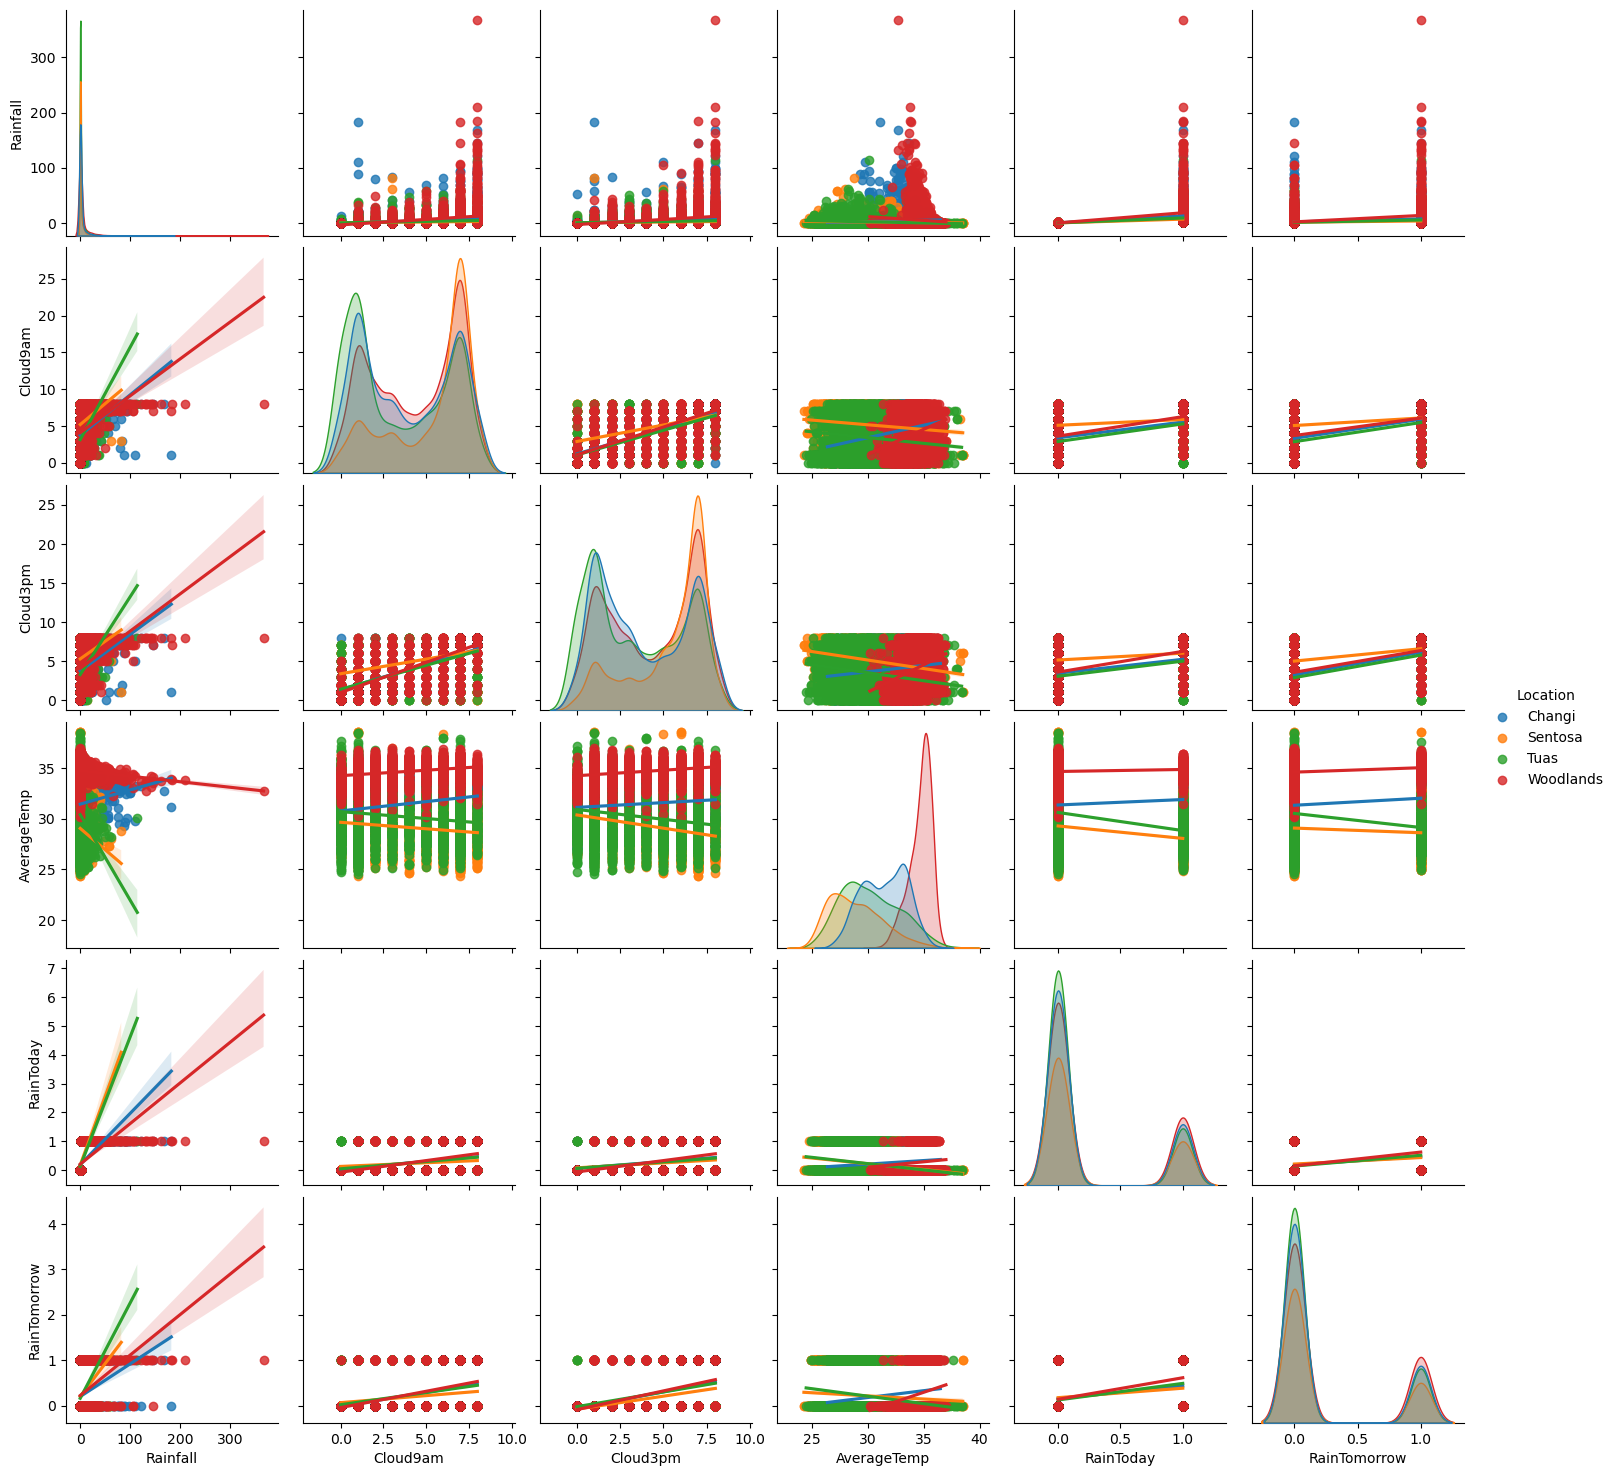

In [36]:
sns.pairplot(df[['Rainfall','Cloud9am','Cloud3pm','AverageTemp','RainToday','RainTomorrow','Location']],hue='Location',kind="reg")

## now lets see the correlation matrix for the data

<Axes: >

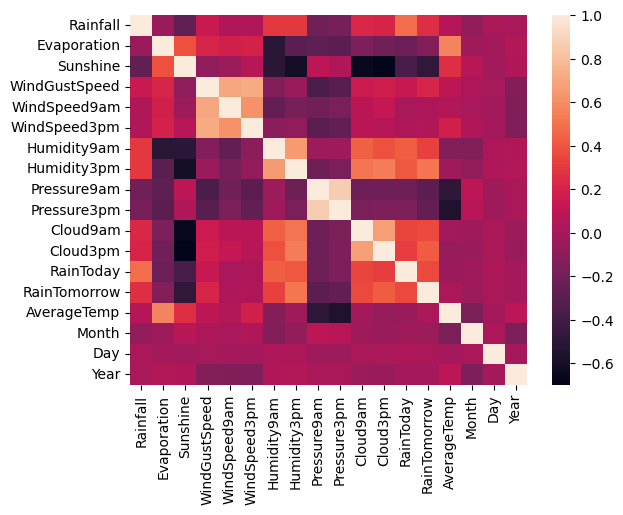

In [37]:
numeric_cols = df.select_dtypes(include=['int', 'float']).columns

correlation_matrix = df[numeric_cols].corr()

numeric_cols.drop(['Pressure9am','Pressure3pm','Year','Month','Day'])

sns.heatmap(correlation_matrix)

## boxplots for outliers detestions

The meadian is:  0.0


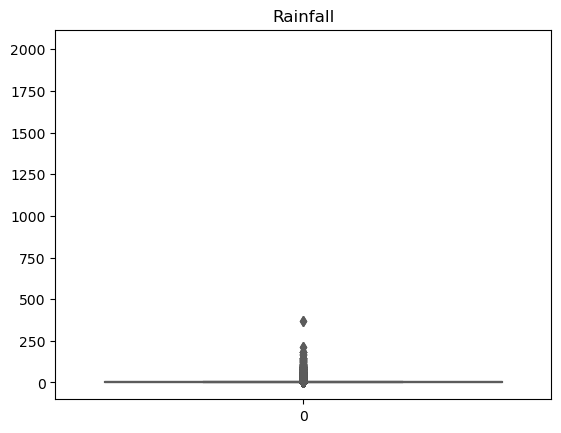

The meadian is:  5.4


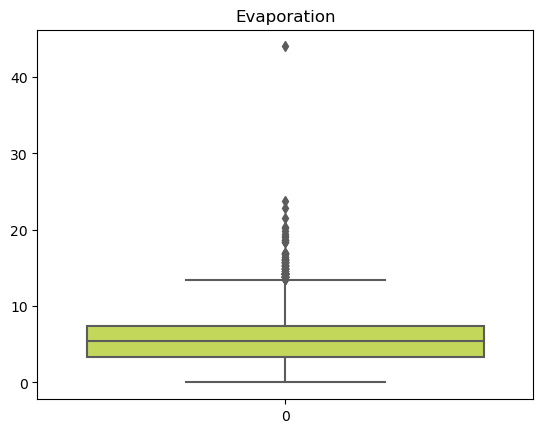

The meadian is:  9.2


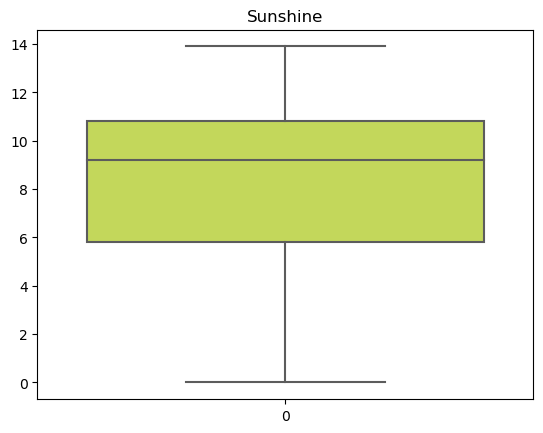

The meadian is:  35.0


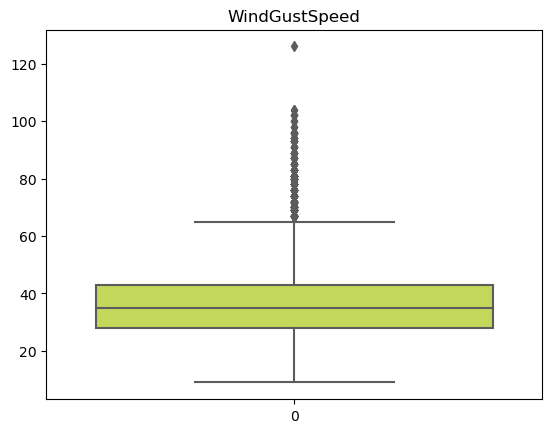

The meadian is:  11.0


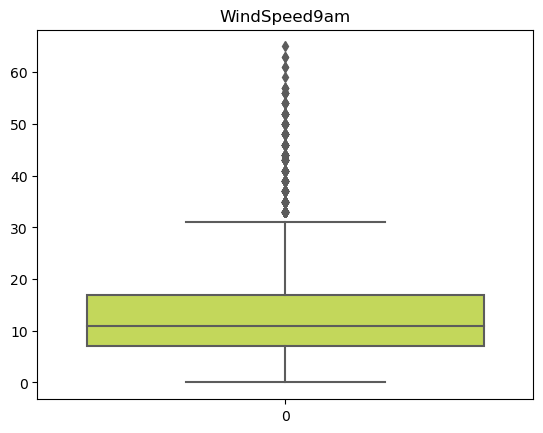

The meadian is:  15.0


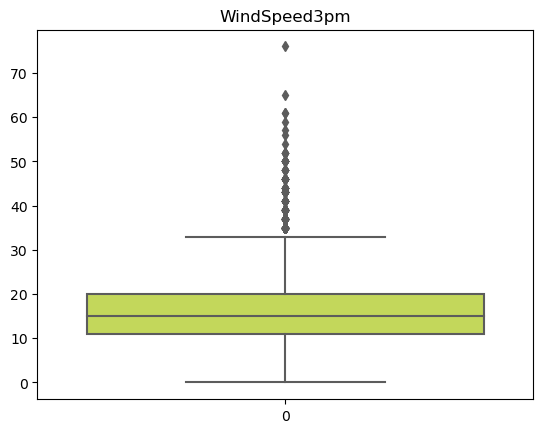

The meadian is:  66.0


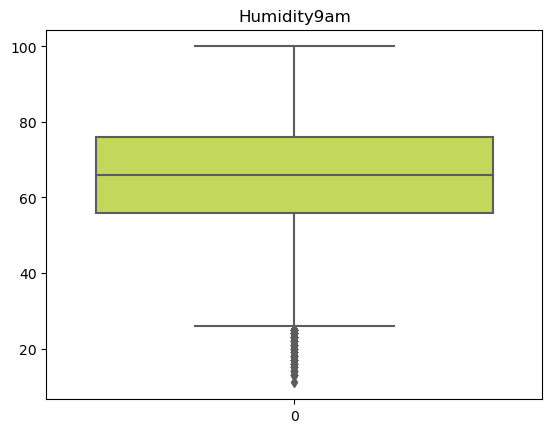

The meadian is:  51.0


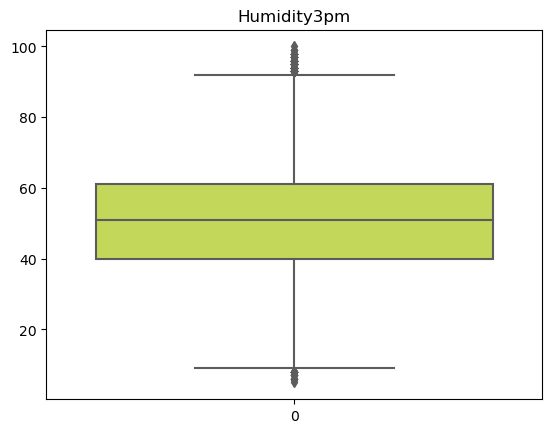

The meadian is:  2.0


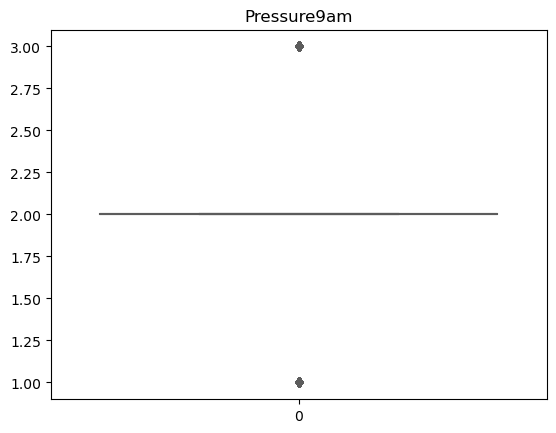

The meadian is:  2.0


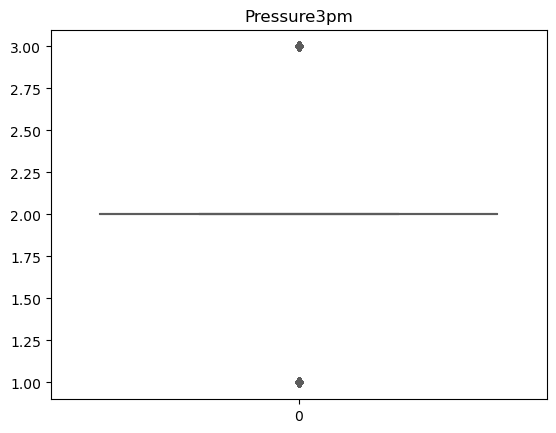

The meadian is:  5.0


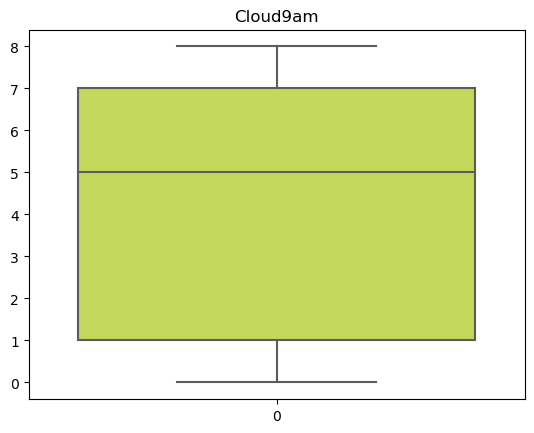

The meadian is:  4.0


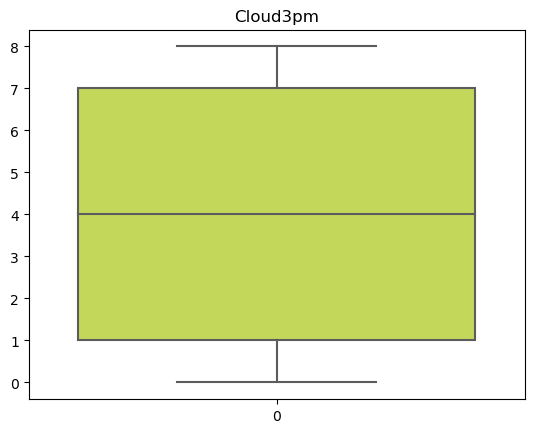

The meadian is:  0.0


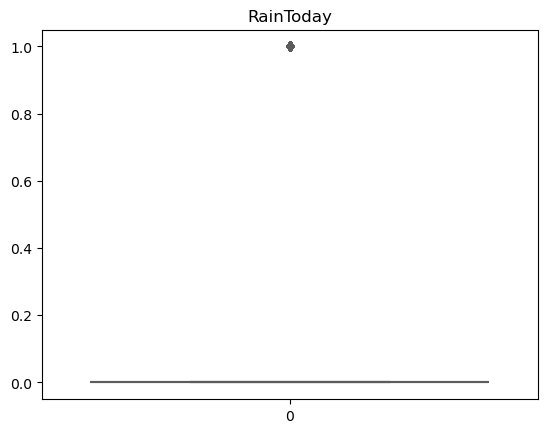

The meadian is:  0.0


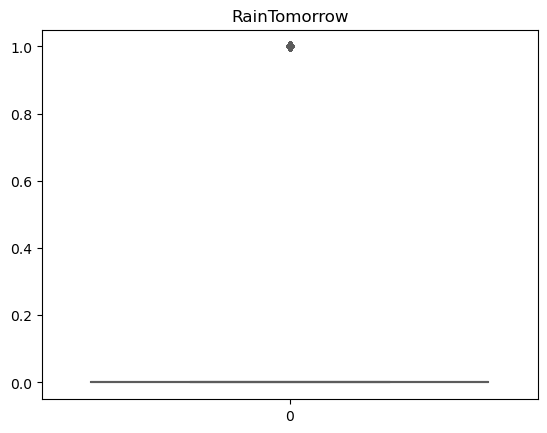

The meadian is:  31.7


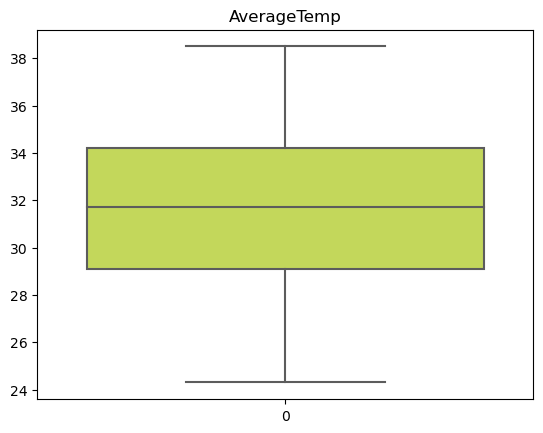

The meadian is:  7.0


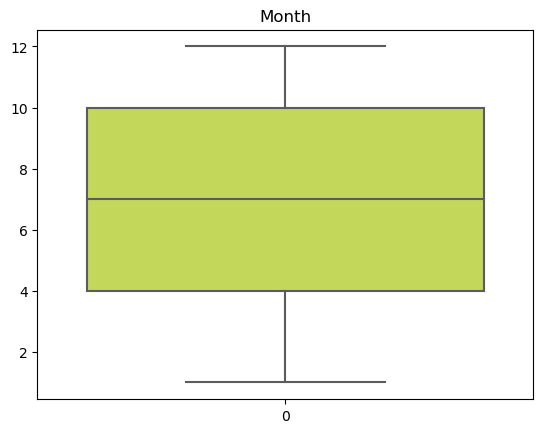

The meadian is:  16.0


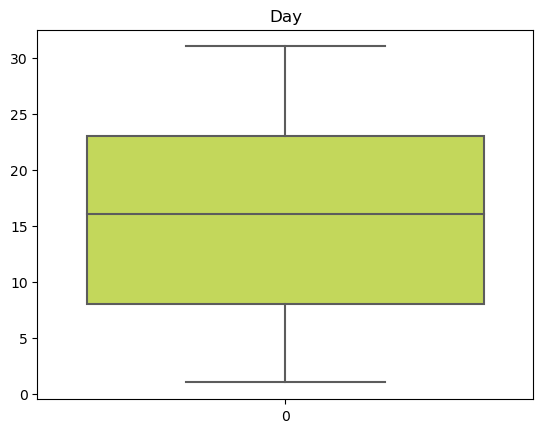

The meadian is:  2012.0


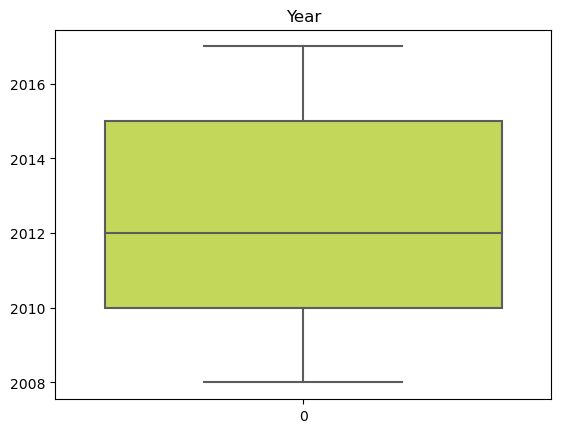

In [38]:
sns.boxplot(df[numeric_cols].values,orient='v')


for c in numeric_cols:
    x = df[c].values
    ax = sns.boxplot(x, color = '#D1EC46',orient='v')
    print('The meadian is: ', df[c].median())
    plt.title(c)
    plt.show()

In [39]:
df=new_df.copy()

### filling some unbelievable data with rolling mean

Series([], Name: Evaporation, dtype: float64)


C:\Users\LEGION\AppData\Local\Temp\ipykernel_18868\2397967486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Evaporation'][df['Evaporation'] > 40] = rolling_mean[df['Evaporation'] > 40]


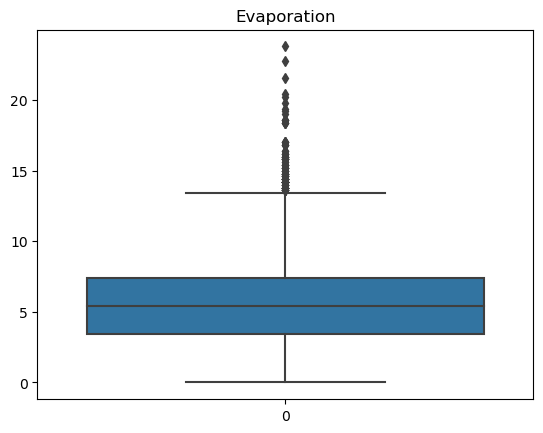

In [40]:
rolling_mean = df['Evaporation'].rolling(window=5).mean()
df['Evaporation'][df['Evaporation'] > 40] = rolling_mean[df['Evaporation'] > 40]
print(rolling_mean[df['Evaporation'] > 40])
sns.boxplot(df['Evaporation'].values)
plt.title('Evaporation')
plt.show()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_18868\2731077143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WindGustSpeed'][outlier_condition] = rolling_mean[outlier_condition]


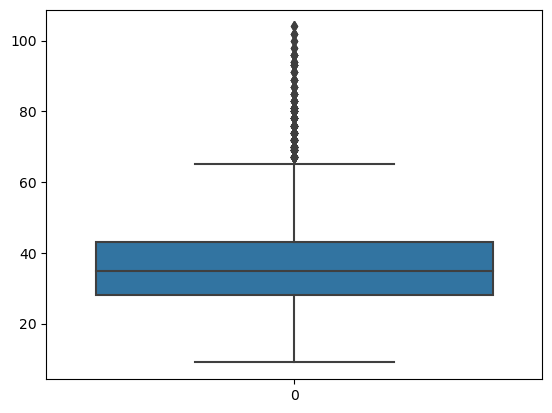

In [41]:
rolling_mean = df['WindGustSpeed'].rolling(window=5).mean()
outlier_condition = df['WindGustSpeed'] > 120
df['WindGustSpeed'][outlier_condition] = rolling_mean[outlier_condition]
sns.boxplot(df['WindGustSpeed'].values)
plt.show()

Series([], Name: Rainfall, dtype: float64)


C:\Users\LEGION\AppData\Local\Temp\ipykernel_18868\3310197286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rainfall'][df['Rainfall']>350] = rolling_mean[df['Rainfall']>350]


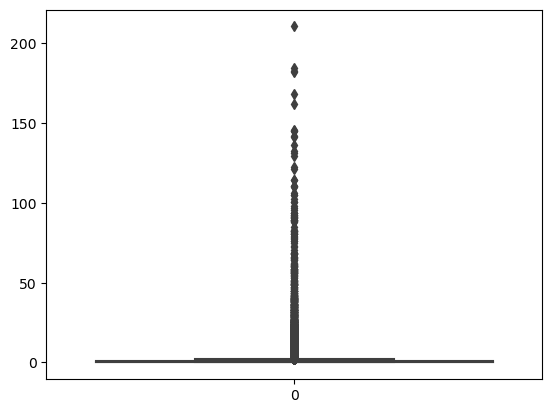

In [42]:
rolling_mean = df['Rainfall'].rolling(5).mean()
df['Rainfall'][df['Rainfall']>350] = rolling_mean[df['Rainfall']>350]
print(rolling_mean[df['Rainfall']>350])
sns.boxplot(df['Rainfall'].values)
plt.show()

check for null data

In [43]:
df.isnull().sum()

Location         0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
RainToday        0
RainTomorrow     0
AverageTemp      0
Month            0
Day              0
Year             0
dtype: int64

categorizing the wind direction column

In [44]:
def encode_wind_directions(df, column_name):
    # Create the direction columns
    direction_columns = [f'{column_name}_N', f'{column_name}_S', f'{column_name}_E', f'{column_name}_W']
    for column in direction_columns:
        df[column] = 0

    # Iterate through the DataFrame and update direction columns
    for index, row in df.iterrows():
        wind_direction = row[column_name]
        if isinstance(wind_direction, str):
            for char in wind_direction:
                if char == 'N':
                    df.at[index, f'{column_name}_N'] += 1
                elif char == 'S':
                    df.at[index, f'{column_name}_S'] += 1
                elif char == 'E':
                    df.at[index, f'{column_name}_E'] += 1
                elif char == 'W':
                    df.at[index, f'{column_name}_W'] += 1

    # Drop the original column
    df.drop(columns=[column_name], inplace=True)

In [45]:
temp_df=df.copy()
for cols in 'WindGustDir','WindDir9am','WindDir3pm':
    encode_wind_directions(temp_df,cols)


### one hottie encoding...

In [46]:
encoder = OneHotEncoder()
temp_df['Location'] = temp_df['Location'].astype('category')
one_hot_encoded = pd.get_dummies(temp_df['Location'], prefix='Location')
temp_df = pd.concat([temp_df, one_hot_encoded], axis=1)
temp_df.drop(columns=['Location'], inplace=True)

temp_df

,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir9am_E,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_E,WindDir3pm_W,Location_Changi,Location_Sentosa,Location_Tuas,Location_Woodlands
0,0.0,1.4,9.5,26.0,6,15,81.0,37.0,2,2,...,0,1,0,0,0,1,1,0,0,0
1,0.0,2.0,9.8,30.0,15,19,41.0,30.0,2,2,...,0,1,1,0,0,2,1,0,0,0
2,0.0,5.8,9.4,22.0,7,15,55.0,52.0,2,3,...,0,1,0,0,1,0,1,0,0,0
3,0.8,1.8,1.1,24.0,9,7,76.0,53.0,3,3,...,0,1,0,2,1,0,1,0,0,0
4,0.0,2.0,0.3,37.0,11,7,81.0,89.0,3,3,...,0,0,0,2,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12992,0.0,6.0,11.0,35.0,9,20,63.0,32.0,2,2,...,1,0,1,0,1,0,0,0,0,1
12993,0.0,7.6,8.6,37.0,13,11,56.0,28.0,2,2,...,1,0,0,1,1,0,0,0,0,1
12994,0.0,5.6,11.0,33.0,17,11,46.0,23.0,2,2,...,1,0,0,0,0,1,0,0,0,1
12995,0.0,6.2,10.6,26.0,9,17,62.0,58.0,2,2,...,1,0,2,0,0,1,0,0,0,1


In [47]:
df=temp_df.copy()

mscaler = MinMaxScaler()  # Or: StandardScaler()
sscaler=StandardScaler()

StandardScaler_scaled_data = sscaler.fit_transform(df.drop(['RainTomorrow'],axis=1))
Min_Max_scaled_data = mscaler.fit_transform(df.drop(['RainTomorrow'],axis=1))

## Correlation Matrix

                    Rainfall  Evaporation  Sunshine  WindGustSpeed  \
Rainfall            1.000000    -0.049974 -0.280301       0.138137   
Evaporation        -0.049974     1.000000  0.378713       0.213211   
Sunshine           -0.280301     0.378713  1.000000      -0.081696   
WindGustSpeed       0.138137     0.213211 -0.081696       1.000000   
WindSpeed9am        0.035986     0.183426 -0.035765       0.698890   
WindSpeed3pm        0.030664     0.193499  0.067016       0.720765   
Humidity9am         0.302298    -0.513675 -0.508694      -0.138510   
Humidity3pm         0.301560    -0.299833 -0.609899      -0.043597   
Pressure9am        -0.214350    -0.287302  0.094371      -0.361003   
Pressure3pm        -0.187702    -0.294874  0.037737      -0.313276   
Cloud9am            0.236665    -0.161092 -0.662002       0.144676   
Cloud3pm            0.215502    -0.215664 -0.699282       0.176590   
RainToday           0.498663    -0.231177 -0.372677       0.132401   
RainTomorrow        

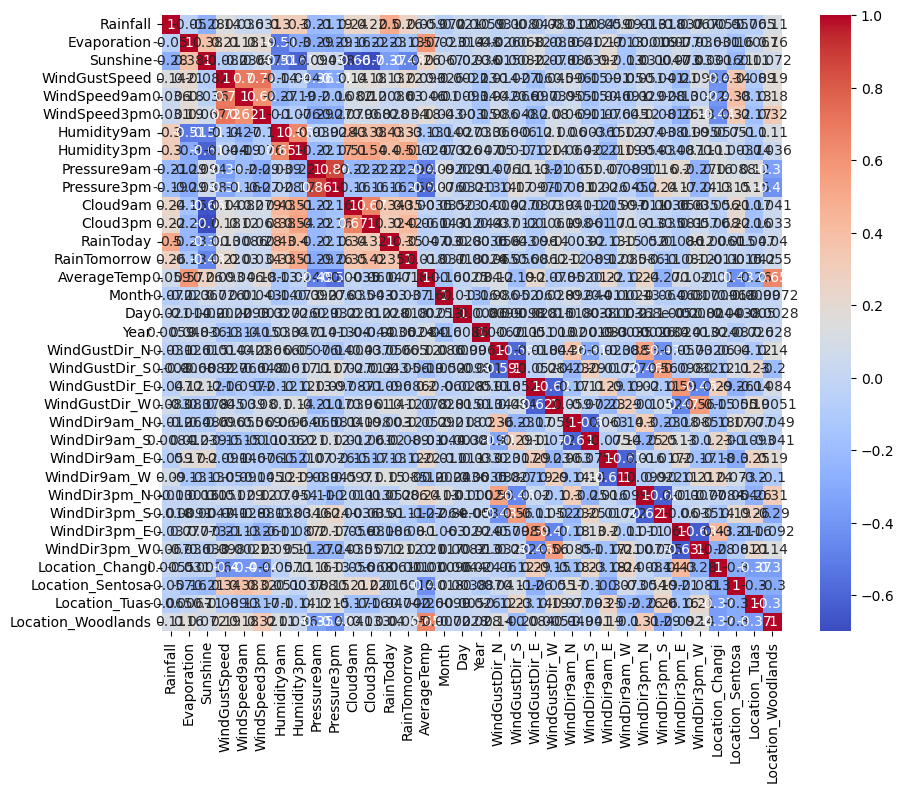

In [48]:

correlation_matrix = df.corr()

print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

we cant understand anything from it so lets go further and look at feature importance

## Looking At Feature Importance through Random Forest Classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Load your data and split it into features (X) and target (y)
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

# Initialize the random forest classifier
rf_classifier = RandomForestClassifier()

# Fit the model to your data
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort and display the top features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False)
print(top_features)

               Feature  Importance
7          Humidity3pm    0.179764
2             Sunshine    0.111669
3        WindGustSpeed    0.055637
11            Cloud3pm    0.053575
6          Humidity9am    0.052687
0             Rainfall    0.049218
13         AverageTemp    0.045415
1          Evaporation    0.039413
15                 Day    0.037393
10            Cloud9am    0.035713
5         WindSpeed3pm    0.032535
4         WindSpeed9am    0.030702
16                Year    0.026470
8          Pressure9am    0.026401
14               Month    0.026365
9          Pressure3pm    0.026040
12           RainToday    0.020356
25        WindDir3pm_N    0.013112
20       WindGustDir_W    0.012626
21        WindDir9am_N    0.012245
28        WindDir3pm_W    0.010903
17       WindGustDir_N    0.010617
18       WindGustDir_S    0.010544
22        WindDir9am_S    0.010319
26        WindDir3pm_S    0.010267
19       WindGustDir_E    0.009743
24        WindDir9am_W    0.009613
23        WindDir9am

looks like most features are important so we cant avoid them...
so lets just not do feature elimination

# Models:-

## Train Test Splitting

In [67]:
from sklearn.metrics import accuracy_score

X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


## Logistic Regression

In [68]:


from sklearn.linear_model import LogisticRegression


logistic_regression_model = LogisticRegression(max_iter=10000)
# logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)



y_pred = logistic_regression_model.predict(X_test)

score = logistic_regression_model.score(X_test, y_test)
print("Accuracy: {:.2f}".format(score*100))
print("Accuracy of Logistic Regression:",accuracy_score(y_test, y_pred))

Accuracy: 86.38
Accuracy of Logistic Regression: 0.8638461538461538


## DecisionTree Classifier

### gini

In [69]:

decision_tree_model = DecisionTreeClassifier(random_state=15, criterion  = 'gini', max_depth = 14)
decision_tree_model.fit(X_train, y_train)

y_pred_decision_tree_model = decision_tree_model.predict(X_test)

score = decision_tree_model.score(X_test, y_test)
print("Accuracy: {:.2f}".format(score*100))
print("Accuracy of Decision tree with gini:",accuracy_score(y_test, y_pred_decision_tree_model))


Accuracy: 83.31
Accuracy of Decision tree with gini: 0.833076923076923


### Entropy

In [70]:
from sklearn import tree


dt = DecisionTreeClassifier(random_state=15, criterion  = 'entropy', max_depth = 13)

dt.fit(X,y)

y_pred_dt = dt.predict(X_test)

score = dt.score(X_test, y_test)
print("Accuracy: {:.2f}".format(score*100))
print("Accuracy of Decision tree with entropy:",accuracy_score(y_test, y_pred_dt))
fig = plt.figure(figsize=(25,20))
# tree.plot_tree(dt, 
#                    feature_names=X.columns,  
#                    class_names=y.name,
#                    filled=True)


Accuracy: 95.77
Accuracy of Decision tree with entropy: 0.9576923076923077


<Figure size 2500x2000 with 0 Axes>

### log_loss

In [71]:

dtl = DecisionTreeClassifier(random_state=15, criterion  = 'log_loss',min_samples_split=8)
dtl.fit(X,y)
y_pred_dtl = dtl.predict(X_test)

score = dtl.score(X_test, y_test)
print("Accuracy: {:.2f}".format(score*100))
print("Accuracy of Decision tree with log_loss:",accuracy_score(y_test, y_pred_dtl))


Accuracy: 96.92
Accuracy of Decision tree with log_loss: 0.9692307692307692


## Random Forest Model

### Gini

In [72]:

random_forest_model = RandomForestClassifier(random_state=15, criterion  = 'gini',max_depth=14)
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)

score = random_forest_model.score(X_test, y_test)
print("Accuracy: {:.2f}".format(score*100))
print("Accuracy of Random Forest Classifier:",accuracy_score(y_test, y_pred))



Accuracy: 88.31
Accuracy of Random Forest Classifier: 0.8830769230769231


### Entropy

In [73]:

random_forest_model = RandomForestClassifier(random_state=15, criterion  = 'entropy',max_depth=13)
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)

score = random_forest_model.score(X_test, y_test)
print("Accuracy: {:.2f}".format(score*100))
print("Accuracy of Random Forest Classifier:",accuracy_score(y_test, y_pred))



Accuracy: 88.65
Accuracy of Random Forest Classifier: 0.8865384615384615


### log_loss

In [74]:

random_forest_model = RandomForestClassifier(random_state=15, criterion  = 'log_loss',min_samples_split=8)
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)

score = random_forest_model.score(X_test, y_test)
print("Accuracy: {:.2f}".format(score*100))
print("Accuracy of Random Forest Classifier:",accuracy_score(y_test, y_pred))

Accuracy: 88.54
Accuracy of Random Forest Classifier: 0.8853846153846154


## XGBoost, LightGBM, CatBoost

In [58]:
import xgboost
import lightgbm as lgb
import catboost as cb

xgb_model = xgboost.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Create and fit the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# Create and fit the CatBoost model
cb_model = cb.CatBoostClassifier()
cb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_cb = cb_model.predict(X_test)

score = xgb_model.score(X_test, y_test)
print("Accuracy of xgb_model: {:.2f}".format(score*100))
print("Accuracy of xgb_model:",accuracy_score(y_test, y_pred_xgb))
score = lgb_model.score(X_test, y_test)
print("Accuracy of lgb_model: {:.2f}".format(score*100))
print("Accuracy of lgb_model:",accuracy_score(y_test, y_pred_lgb))
score = cb_model.score(X_test, y_test)
print("Accuracy of cb_model: {:.2f}".format(score*100))
print("Accuracy of cb_model:",accuracy_score(y_test, y_pred_cb))

[LightGBM] [Info] Number of positive: 2356, number of negative: 8041
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 10397, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226604 -> initscore=-1.227588
[LightGBM] [Info] Start training from score -1.227588
Learning rate set to 0.028
0:	learn: 0.6702827	total: 131ms	remaining: 2m 10s
1:	learn: 0.6486618	total: 151ms	remaining: 1m 15s
2:	learn: 0.6285570	total: 163ms	remaining: 54.1s
3:	learn: 0.6117620	total: 172ms	remaining: 42.8s
4:	learn: 0.5935242	total: 179ms	remaining: 35.7s
5:	learn: 0.5773798	total: 186ms	remaining: 30.8s
6:	learn: 0.5610779	total: 193ms	remaining: 27.3s
7:	learn: 0.5459075	total: 199ms	remaining: 24.7s
8:	learn: 0.

## Support Vector Classifier

In [76]:
from sklearn.svm import SVC


svm_model = SVC(kernel="linear") # tried all but linear gives best output.
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

score = svm_model.score(X_test, y_test)
print("Accuracy of svm_model: {:.2f}".format(score*100))
print("Accuracy of svm:{:.2f}".format(accuracy_score(y_test, y_pred)*100))

Accuracy of svm_model: 86.00
Accuracy of svm:86.00


## Gradient Boost

In [60]:
from sklearn.ensemble import GradientBoostingClassifier


gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_train)

print('The Accuracy  on the testing dataset is: {:.2f}'.format(gbc.score(X_test, y_test)*100))


The Accuracy  on the testing dataset is: 87.54


## Neural Network

In [61]:

neural_network_model = Sequential()

input_dim = X_train.shape[1]

# Add layers to the model
neural_network_model.add(Dense(64, activation='relu', input_dim=input_dim))
neural_network_model.add(Dense(64, activation='relu'))
neural_network_model.add(Dense(1, activation='sigmoid'))

# Compile the model
neural_network_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to the training data
neural_network_model.fit(X_train, y_train, epochs=50, batch_size=46)

# Predict on the test set
y_pred_prob = neural_network_model.predict(X_test)
classes_x=np.argmax(y_pred)
y_pred = (y_pred_prob > 0.5).astype(int)


Epoch 1/50
227/227 [==============================] - 1s 1ms/step - loss: 2.8641 - accuracy: 0.7423
Epoch 2/50
227/227 [==============================] - 0s 1ms/step - loss: 0.6640 - accuracy: 0.7872
Epoch 3/50
227/227 [==============================] - 0s 1ms/step - loss: 0.5373 - accuracy: 0.8109
Epoch 4/50
227/227 [==============================] - 0s 1ms/step - loss: 0.5296 - accuracy: 0.8159
Epoch 5/50
227/227 [==============================] - 0s 1ms/step - loss: 0.4952 - accuracy: 0.8199
Epoch 6/50
227/227 [==============================] - 0s 1ms/step - loss: 0.4650 - accuracy: 0.8293
Epoch 7/50
227/227 [==============================] - 0s 1ms/step - loss: 0.4756 - accuracy: 0.8226
Epoch 8/50
227/227 [==============================] - 0s 1ms/step - loss: 1.2570 - accuracy: 0.7796
Epoch 9/50
227/227 [==============================] - 0s 1ms/step - loss: 0.5717 - accuracy: 0.8242
Epoch 10/50
227/227 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.8174

In [65]:
print("Accuracy of neural_network_model:{:.2f}".format(accuracy_score(y_test, y_pred)*100))

Accuracy of neural_network_model:86.42


## Naive Bayes Gaussian and Bernaulli with KFold

In [64]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn import metrics
import numpy as np
from sklearn.naive_bayes import BernoulliNB as bnb

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=16)

kf = KFold(n_splits=40)
acc_gnb=[]
acc_bnb=[]
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    # print("---------------------------------------------------------------------------------")
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")
    current_X_train = X_train.iloc[train_index]
    current_Y_train = Y_train.iloc[train_index]
    current_X_test = X_train.iloc[train_index]
    current_Y_test = Y_train.iloc[train_index]
    gnb_model = GaussianNB()
    gnb_model = gnb_model.fit(current_X_train, current_Y_train)
    current_Y_pred_gnb=gnb_model.predict(current_X_test)
    acc_gnb.insert(i,metrics.accuracy_score(current_Y_test,current_Y_pred_gnb))
    bnb_model = bnb()
    bnb_model.fit(current_X_train, current_Y_train)
    current_Y_pred_bnb = bnb_model.fit(current_X_train, current_Y_train).predict(current_X_test)
    # print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (Y_test != current_Y_pred_bnb).sum()))
    acc_bnb.insert(i,metrics.accuracy_score(current_Y_test,current_Y_pred_bnb))
    # print(acc_gnb[i])
    # print(acc_bnb[i])

print("gaussian",np.mean(acc_gnb,axis=0)*100)
print('burnouli',np.mean(acc_bnb,axis=0)*100)

gaussian 81.54403004106791
burnouli 77.17407413059956


# Conclusion:

the ones giving above 85% accuracy...
- Logistic regression: 86.38%
- Decision Tree Classifier:-
    - gini: 83.31%
    - Entropy: 95.77%
    - log_loss: 96.92%
- Random Forest:-
    - gini: 88.31%
    - Entropy: 89.65%
    - log_loss: 88.54%
- X Gradient Boost Model : 88.04%
- Light Gradient Boost Model : 87.35%
- Cat Boost Model : 88.46%
- Gradient Boost Model : 87.54%
- Support Vector Classifier: 86.00%
- Neural Network : 86.42%

So here we conclude this Problem eith the log_loss as the winner for nearly 97% accuracy score